In [1]:
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set() 
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from datetime import datetime, timedelta
from alive_progress import alive_bar, alive_it 
from random import random, seed

matches_dataset = pd.read_csv("all_matches_dataset.csv")
matches_dataset

,match_url,match_date,winner,map,t1_name,t1_rank,t1_id,t1_total_rw,t1_fh_rw,t1_sh_rw,...,t2p5_kills,t2p5_hskills,t2p5_assists,t2p5_fassists,t2p5_deaths,t2p5_kdratio,t2p5_kddiff,t2p5_adr,t2p5_fkdiff,t2p5_rating
0,/stats/matches/mapstatsid/46584/hellraisers-vs...,2017-05-17,t1,train,hellraisers,8.0,5310,16,13,3,...,5.0,2.0,1.0,0.0,17.0,0.333,-12.0,35.9,-3.0,0.26
1,/stats/matches/mapstatsid/62534/envy-vs-north,2018-03-08,t1,cobblestone,north,13.0,7533,16,8,8,...,15.0,9.0,1.0,0.0,22.0,0.633,-7.0,58.5,-3.0,0.78
2,/stats/matches/mapstatsid/61361/fnatic-vs-gambit,2018-02-17,t1,inferno,fnatic,5.0,4991,16,10,6,...,7.0,5.0,3.0,1.0,22.0,0.458,-15.0,49.2,-3.0,0.37
3,/stats/matches/mapstatsid/57159/liquid-vs-cloud9,2017-11-12,t2,overpass,liquid,8.0,5973,5,3,2,...,16.0,5.0,3.0,0.0,16.0,0.714,0.0,67.6,0.0,1.00
4,/stats/matches/mapstatsid/123194/dbl-poney-vs-ago,2021-07-04,t1,ancient,dbl-poney,25.0,11003,16,6,10,...,15.0,10.0,2.0,0.0,22.0,0.567,-7.0,64.6,-1.0,0.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35401,/stats/matches/mapstatsid/65153/pride-vs-ago,2018-04-13,t1,train,ago,21.0,8068,16,6,10,...,14.0,6.0,3.0,0.0,20.0,0.630,-6.0,50.9,-3.0,0.75
35402,/stats/matches/mapstatsid/99605/boom-vs-imperial,2020-03-05,t2,mirage,imperial,NaN,9455,9,7,2,...,18.0,12.0,3.0,1.0,17.0,0.720,1.0,69.0,0.0,1.03
35403,/stats/matches/mapstatsid/83004/beyond-vs-fros...,2019-03-21,t2,cache,beyond,NaN,8262,15,6,9,...,19.0,4.0,8.0,2.0,26.0,0.559,-7.0,57.3,0.0,0.83
35404,/stats/matches/mapstatsid/98764/bad-news-bears...,2020-02-15,t1,mirage,bad-news-bears,NaN,9799,16,14,2,...,4.0,1.0,0.0,0.0,16.0,0.235,-12.0,26.6,-7.0,0.22


In [19]:
# def filter_dataset_by_date(full_df, start_dt : datetime, stop_dt : datetime, date_col_name : str = "match_date"):
#     df : DataFrame = full_df.copy()
#     if start_dt > stop_dt:
#         print("datetimes were given backwards")
#         temp_dt = start_dt
#         start_dt = stop_dt
#         stop_dt = temp_dt
#     with alive_bar(df.shape[0], bar="filling", length=30, title="Filtering... ") as bar:
#         for index, row in df.iterrows():
#             if (dt:=datetime.strptime(row[date_col_name], '%Y-%m-%d')) < start_dt or dt >= stop_dt:
#                 df.drop(index, inplace=True)
#             bar()
#     return df

# keep_indeces = []
# keep_rows = []
def filter_dataset_by_date(full_df, start_dt : datetime, stop_dt : datetime, date_col_name : str = "match_date"):
    df : DataFrame = full_df.copy()
    keep_dict = {}
    if start_dt > stop_dt:
        print("datetimes were given backwards")
        temp_dt = start_dt
        start_dt = stop_dt
        stop_dt = temp_dt
    with alive_bar(df.shape[0], bar="filling", length=30, title="Filtering... ") as bar:
        for index, row in df.iterrows():
            if not((dt:=datetime.strptime(row[date_col_name], '%Y-%m-%d')) < start_dt or dt >= stop_dt):
                # keep_indeces.append(index)
                # keep_rows.append(row)
                keep_dict[index] = row 
            bar()
    return DataFrame.from_dict(keep_dict,orient="index")


    

recent_matches_dataset = filter_dataset_by_date(matches_dataset, date_col_name="match_date", start_dt = datetime.now() - timedelta(days=180), stop_dt = datetime.now())

def partition_dataset_by_date(df : DataFrame, stop_date = "2017-08-01", partition_length : int = 120, overlapping : bool = True, partition_shift : int = 30) -> dict[str, DataFrame]:
    partitions = {}
    stop_dt = datetime.strptime(stop_date, '%Y-%m-%d')
    dt_it = datetime.now()
    if not overlapping:
        partition_shift = partition_length
    while dt_it - timedelta(days=(partition_length)) > stop_dt:
        partition = filter_dataset_by_date(df, date_col_name= "match_date", start_dt=dt_it - timedelta(days = partition_shift), stop_dt=dt_it)
        date_range = f"{datetime.strftime(dt_it - timedelta(days = partition_length),'%Y-%m-%d')} -> {datetime.strftime(dt_it,'%Y-%m-%d')}"
        partitions[date_range] = partition
        print(date_range,":",partition.shape[0],"items in partition")
        dt_it = dt_it - timedelta(days=partition_shift)
    return Series(partitions)
dataset_partitions = partition_dataset_by_date(matches_dataset, stop_date="2020-01-01")
dataset_partitions.iloc[0]

Filtering...  |██████████████████████████████| 35406/35406 [100%] in 3.5s (10183.78/s)
Filtering...  |██████████████████████████████| 35406/35406 [100%] in 3.9s (9136.07/s)
2021-12-11 -> 2022-04-10 : 545 items in partition
Filtering...  |██████████████████████████████| 35406/35406 [100%] in 4.0s (8854.71/s)
2021-11-11 -> 2022-03-11 : 624 items in partition
Filtering...  |██████████████████████████████| 35406/35406 [100%] in 3.8s (9218.18/s)
2021-10-12 -> 2022-02-09 : 369 items in partition
Filtering...  |██████████████████████████████| 35406/35406 [100%] in 4.8s (7420.28/s)
2021-09-12 -> 2022-01-10 : 219 items in partition
Filtering...  |██████████████████████████████| 35406/35406 [100%] in 4.4s (8091.08/s)
2021-08-13 -> 2021-12-11 : 836 items in partition
Filtering...  |██████████████████████████████| 35406/35406 [100%] in 4.0s (8823.02/s)
2021-07-14 -> 2021-11-11 : 550 items in partition
Filtering...  |██████████████████████████████| 35406/35406 [100%] in 3.7s (9695.27/s)
2021-06-14 

,match_url,match_date,winner,map,t1_name,t1_rank,t1_id,t1_total_rw,t1_fh_rw,t1_sh_rw,...,t2p5_kills,t2p5_hskills,t2p5_assists,t2p5_fassists,t2p5_deaths,t2p5_kdratio,t2p5_kddiff,t2p5_adr,t2p5_fkdiff,t2p5_rating
15000,/stats/matches/mapstatsid/135667/faze-vs-furia,2022-03-20,t1,mirage,faze,3.0,6667,16,10,6,...,10.0,3.0,2.0,1.0,19.0,0.586,-9.0,36.2,-6.0,0.61
15001,/stats/matches/mapstatsid/135673/ence-vs-sprout,2022-03-20,t1,ancient,ence,15.0,4869,16,8,8,...,13.0,8.0,7.0,4.0,18.0,0.667,-5.0,52.2,-3.0,0.80
15002,/stats/matches/mapstatsid/135496/furia-vs-sprout,2022-03-17,t1,ancient,furia,14.0,8297,16,11,5,...,11.0,2.0,4.0,2.0,19.0,0.481,-8.0,37.9,-2.0,0.54
15003,/stats/matches/mapstatsid/135237/g2-vs-nip,2022-03-13,t1,vertigo,g2,NaN,5995,16,13,3,...,5.0,2.0,5.0,2.0,17.0,0.550,-12.0,44.3,-2.0,0.50
15005,/stats/matches/mapstatsid/135613/sprout-vs-out...,2022-03-19,t1,dust2,outsiders,NaN,11595,16,12,4,...,6.0,4.0,1.0,1.0,16.0,0.450,-10.0,35.6,-3.0,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35314,/stats/matches/mapstatsid/136215/finest-vs-1win,2022-03-29,t1,overpass,1win,NaN,10621,16,9,7,...,14.0,8.0,7.0,1.0,19.0,0.483,-5.0,64.4,-1.0,0.83
35317,/stats/matches/mapstatsid/136428/uyu-vs-limitless,2022-04-01,t2,inferno,uyu,NaN,11076,11,7,4,...,9.0,6.0,7.0,5.0,17.0,0.704,-8.0,40.8,-3.0,0.68
35350,/stats/matches/mapstatsid/136043/sws-vs-freestyle,2022-03-27,t1,overpass,freestyle,NaN,11593,16,9,7,...,16.0,7.0,5.0,1.0,21.0,0.654,-5.0,75.4,0.0,0.75
35393,/stats/matches/mapstatsid/135987/rare-atom-vs-...,2022-03-26,t1,ancient,tyloo,NaN,4863,16,8,8,...,12.0,7.0,4.0,1.0,19.0,0.679,-7.0,50.1,-2.0,0.77


In [31]:
recent_matches_dataset = dataset_partitions.iloc[0]
recent_matches_dataset

,match_url,match_date,winner,map,t1_name,t1_rank,t1_id,t1_total_rw,t1_fh_rw,t1_sh_rw,...,t2p5_kills,t2p5_hskills,t2p5_assists,t2p5_fassists,t2p5_deaths,t2p5_kdratio,t2p5_kddiff,t2p5_adr,t2p5_fkdiff,t2p5_rating
15000,/stats/matches/mapstatsid/135667/faze-vs-furia,2022-03-20,t1,mirage,faze,3.0,6667,16,10,6,...,10.0,3.0,2.0,1.0,19.0,0.586,-9.0,36.2,-6.0,0.61
15001,/stats/matches/mapstatsid/135673/ence-vs-sprout,2022-03-20,t1,ancient,ence,15.0,4869,16,8,8,...,13.0,8.0,7.0,4.0,18.0,0.667,-5.0,52.2,-3.0,0.80
15002,/stats/matches/mapstatsid/135496/furia-vs-sprout,2022-03-17,t1,ancient,furia,14.0,8297,16,11,5,...,11.0,2.0,4.0,2.0,19.0,0.481,-8.0,37.9,-2.0,0.54
15003,/stats/matches/mapstatsid/135237/g2-vs-nip,2022-03-13,t1,vertigo,g2,NaN,5995,16,13,3,...,5.0,2.0,5.0,2.0,17.0,0.550,-12.0,44.3,-2.0,0.50
15005,/stats/matches/mapstatsid/135613/sprout-vs-out...,2022-03-19,t1,dust2,outsiders,NaN,11595,16,12,4,...,6.0,4.0,1.0,1.0,16.0,0.450,-10.0,35.6,-3.0,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35314,/stats/matches/mapstatsid/136215/finest-vs-1win,2022-03-29,t1,overpass,1win,NaN,10621,16,9,7,...,14.0,8.0,7.0,1.0,19.0,0.483,-5.0,64.4,-1.0,0.83
35317,/stats/matches/mapstatsid/136428/uyu-vs-limitless,2022-04-01,t2,inferno,uyu,NaN,11076,11,7,4,...,9.0,6.0,7.0,5.0,17.0,0.704,-8.0,40.8,-3.0,0.68
35350,/stats/matches/mapstatsid/136043/sws-vs-freestyle,2022-03-27,t1,overpass,freestyle,NaN,11593,16,9,7,...,16.0,7.0,5.0,1.0,21.0,0.654,-5.0,75.4,0.0,0.75
35393,/stats/matches/mapstatsid/135987/rare-atom-vs-...,2022-03-26,t1,ancient,tyloo,NaN,4863,16,8,8,...,12.0,7.0,4.0,1.0,19.0,0.679,-7.0,50.1,-2.0,0.77


In [22]:
def get_matches_by_team(df, team_name : str):

    # start = df.columns.get_loc("t2_name") 
    # end = df.columns.get_loc("t2p5_rating") 
    # if df["t1_name"] == team_name.lower():
    #     start = df.columns.get_loc("t2_name") 
    #     end = df.columns.get_loc("t2p5_rating") 
    #     df.drop(columns=df.columns[start : end], inplace=True)
    #     print
    # else:
    #     pass
    return df.loc[ ((df["t1_name"] == team_name.lower()) 
                                | (df["t2_name"] == team_name.lower())) , :]

g2_matches_df = get_matches_by_team(recent_matches_dataset, "G2")
faze_matches_df = get_matches_by_team(recent_matches_dataset, "FaZe")

# print(g2_matches_df.info())
# print("")
# print(faze_matches_df.info())



In [23]:
PLAYER_STAT_VARIABLES = [var.replace("t1p1_","") for var in list(matches_dataset.columns) if ("t1p1_" in var) and (not "player" in var)]

print("All player stats variables:", ", ".join(PLAYER_STAT_VARIABLES))

def get_aggregate_players_stats(df : DataFrame, pstat_vars = PLAYER_STAT_VARIABLES):
    teams_pstats = {}

    for index, row in df.iterrows():
        for tn in (1,2):
            # score_diff = row["t1_total_rw"] - row["t2_total_rw"] if tn==1 else row["t2_total_rw"] - row["t1_total_rw"]
            tname = row[f"t{tn}_name"]
            
            for pn in (1,2,3,4,5):
                id = f"t{tn}p{pn}_"
                pname = row[id+"player"]
                if teams_pstats.get(tname) == None:
                    teams_pstats[tname] = {}
                if teams_pstats[tname].get(pname) == None:
                    teams_pstats[tname][pname] = []
                teams_pstats[tname][pname].append({var:row[id+var] for var in pstat_vars})
    return teams_pstats

All player stats variables: kills, hskills, assists, fassists, deaths, kdratio, kddiff, adr, fkdiff, rating


In [24]:
def get_active_rosters(matches_df) -> dict[str, list[str]]:
    
    # last_two_months = filter_after_date(matches_df, "match_date", datetime.now() - timedelta(days=60))
    
    aggregate_pstats = get_aggregate_players_stats(matches_df)

    teams_active_players = {}
    
    for tname in aggregate_pstats:
        team = aggregate_pstats[tname]
        players_games_played = {}
        # players_games_played =  {player: for player in team}
        for pname in team:
            player = team[pname]
            players_games_played[pname] = len(list(player))
        active_players = list(pd.Series(players_games_played).sort_values(ascending=False).iloc[:5].index)
        teams_active_players[tname] = active_players

    return teams_active_players

def get_sorted_teams_rosters(df : DataFrame, rosters, mode = "mean"):
    aggregated_teams_pstats = get_aggregate_players_stats(df)
    sorted_rosters = {}
    for tname in rosters:
        team = aggregated_teams_pstats[tname]
        pn = 0
        pratings = {}
        for pname in rosters[tname]:
            pmatches = pd.DataFrame(team[pname])
            prating_stats = pmatches.loc[:,["rating"]].describe().squeeze()
            prating_agg_val = prating_stats[mode]
            pratings[pname] = prating_agg_val
        
        sorted_rosters[tname] = list(Series(pratings).sort_values(ascending=False).index)
    return sorted_rosters

active_rosters = get_active_rosters(recent_matches_dataset)
print(active_rosters["g2"])



['huNter-', 'm0NESY', 'NiKo', 'JACKZ', 'Aleksib']


In [30]:

def make_teams_profiles(df : DataFrame, pstat_vars = PLAYER_STAT_VARIABLES, mode = "mean"):
    
    rosters = get_sorted_teams_rosters(df, rosters=get_active_rosters(df))

    aggregated_teams_pstats = get_aggregate_players_stats(df, pstat_vars=pstat_vars)

    teams_profiles = {}
    for tname in rosters:
        team = aggregated_teams_pstats[tname]
        team_flattened_pstats = {}
        pn = 0
        for pname in rosters[tname]:
            pn += 1
            pmatches = pd.DataFrame(team[pname])
            pmatches_stats = pmatches.describe()
            pstats : Series = pmatches_stats.loc[[mode], :].squeeze()
            for index, value in pstats.iteritems():
                team_flattened_pstats[f"p{pn}_{index}"] = value
        teams_profiles[tname] = Series(team_flattened_pstats).astype("float32")
    return teams_profiles


# sorted_rosters = sort_teams_rosters(recent_matches_dataset, rosters=active_rosters)
# print(sorted_rosters["g2"])
many_pstat_vars = ["kills", "assists", "deaths", "kdratio", "kddiff", "adr", "fkdiff", "rating"]
few_pstat_vars = ["kills", "kdratio", "kddiff", "fkdiff", "rating"]
min_pstat_vars = ["kills", "kdratio", "rating"]

# teams_profiles : dict[str,Series]= make_teams_profiles(recent_matches_dataset, pstat_vars=many_pstat_vars)
# teams_profiles : dict[str,Series]= make_teams_profiles(recent_matches_dataset, pstat_vars=few_pstat_vars)
# teams_profiles : dict[str,Series]= make_teams_profiles(recent_matches_dataset, pstat_vars=min_pstat_vars)
teams_profiles : dict[str,Series]= make_teams_profiles(recent_matches_dataset, pstat_vars=["rating"])




AttributeError: 'numpy.float64' object has no attribute 'iteritems'

In [ ]:
print(teams_profiles["g2"].head(10))
print(teams_profiles["g2"].tail(10))

p1_kills      24.600000
p1_kdratio     0.753800
p1_rating      1.316000
p2_kills      25.000000
p2_kdratio     0.695800
p2_rating      1.268000
p3_kills      23.600000
p3_kdratio     0.732600
p3_rating      1.212000
p4_kills      20.799999
dtype: float32
p2_rating      1.268000
p3_kills      23.600000
p3_kdratio     0.732600
p3_rating      1.212000
p4_kills      20.799999
p4_kdratio     0.722200
p4_rating      1.054000
p5_kills      14.200000
p5_kdratio     0.717000
p5_rating      0.910000
dtype: float32


In [ ]:
# convert all unranked teams to have rank of 31st position
model_dataset = recent_matches_dataset.copy()
model_dataset["t1_rank"].fillna(31, inplace=True)
model_dataset["t2_rank"].fillna(31, inplace=True)



# extract data for each team, extract player stats later
teams_stats = model_dataset.loc[:,["t1_rank", "t2_rank", "t1_name", "t2_name"]]

print(teams_stats.shape)
# add team player stat profiles to each entry / row of data in features dataframe
features_dict = {}
for index, row in teams_stats.iterrows():
    row_as_dict = dict(row)
    t1_name, t2_name = row["t1_name"], row["t2_name"]
    if t1_name in teams_profiles or t2_name in teams_profiles:
        if not t1_name in teams_profiles:
            t2_profile = Series(list(teams_profiles[t2_name].values), 
                index = [f"t2{pstat_var}" for pstat_var in list(teams_profiles[t2_name].index)])
            t1_profile = Series(list(teams_profiles[t2_name].apply(lambda x: None).values), 
                index = [f"t1{pstat_var}" for pstat_var in list(teams_profiles[t2_name].index)])
        elif not t2_name in teams_profiles:
            t1_profile = Series(list(teams_profiles[t1_name].values), 
                index = [f"t1{pstat_var}" for pstat_var in list(teams_profiles[t1_name].index)])
            t2_profile = Series(list(teams_profiles[t1_name].apply(lambda x: None).values), 
                index = [f"t2{pstat_var}" for pstat_var in list(teams_profiles[t1_name].index)])
        else:
            t1_profile = Series(list(teams_profiles[t1_name].values), 
                index = [f"t1{pstat_var}" for pstat_var in list(teams_profiles[t1_name].index)])
            t2_profile = Series(list(teams_profiles[t2_name].values), 
                index = [f"t2{pstat_var}" for pstat_var in list(teams_profiles[t2_name].index)])
        
        features_dict[index] = pd.concat([row, t1_profile, t2_profile])
    else:
        model_dataset.drop(index, inplace=True)
    # else:
    #     sad_teams.append(t1_name)
    #     sad_teams.append(t2_name)
    # break

# print(features_dict[list(features_dict.keys())[0]])

features = DataFrame.from_dict(features_dict, orient="index")
features.drop(columns=["t1_name", "t2_name"], inplace=True)
features.fillna(0,inplace=True)

labels = model_dataset["winner"].astype("category")
print(features.shape, labels.shape)
xtrain, xtest, ytrain, ytest = train_test_split( features, labels, random_state=69, test_size=0.3)

# xtrain["t1_name"] = xtrain["t1_name"].astype("category")
# xtrain["t2_name"] = xtrain["t2_name"].astype("category")
# xtest["t1_name"] = xtest["t1_name"].astype("category")
# xtest["t2_name"] = xtest["t2_name"].astype("category")

# xtrain.dtypes


basic_rank_pred = []
for index, row in xtest.iterrows():
    basic_rank_pred.append("t1" if row["t1_rank"] >= row["t2_rank"] else "t2")

print(f'The baseline predictor has a prediction accuracy of {round(accuracy_score(ytest,basic_rank_pred)*100,2)}%')

seed(69)
rand_pred = []
for index, row in xtest.iterrows():
    rand_pred.append("t1" if random() < 0.5 else "t2")

print(f'The random predictor has a prediction accuracy of {round(accuracy_score(ytest,rand_pred)*100,2)}%')

ratio_rank_pred = []
for index, row in xtest.iterrows():
    ratio_rank_pred.append("t1" if random() > float(row["t1_rank"]) / float(row["t1_rank"] + row["t2_rank"]) else "t2")

print(f'The ratio rank predictor has a prediction accuracy of {round(accuracy_score(ytest,ratio_rank_pred)*100,2)}%')


knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(xtrain,ytrain)
# y_pred = knn.predict(xtest)
print(f'The KNeighborsClassifier has a prediction accuracy of {round(knn.score(xtest, ytest)*100,2)}%')


dtc = DecisionTreeClassifier(random_state=69)
dtc.fit(xtrain, ytrain)
# ypred = dtc.predict(xtest)
print(f'The DecisionTreeClassifier has a prediction accuracy of {round(dtc.score(xtest, ytest)*100,2)}%')


rf = RandomForestClassifier(criterion='entropy', n_estimators = 100, random_state = 69)
rf.fit(xtrain, ytrain)
# ypred   = rf.predict(xtest)
print(f'The RandomForestClassifier has a prediction accuracy of {round(rf.score(xtest, ytest)*100,2)}%')


# todo : add feature importance visualiztions for tuning / selecting features to use in the models

(545, 4)
(545, 32) (545,)
The baseline predictor has a prediction accuracy of 48.78%
The random predictor has a prediction accuracy of 48.17%
The ratio rank predictor has a prediction accuracy of 54.27%
The KNeighborsClassifier has a prediction accuracy of 59.15%
The DecisionTreeClassifier has a prediction accuracy of 59.15%
The RandomForestClassifier has a prediction accuracy of 57.32%



-----

## Feature Importances

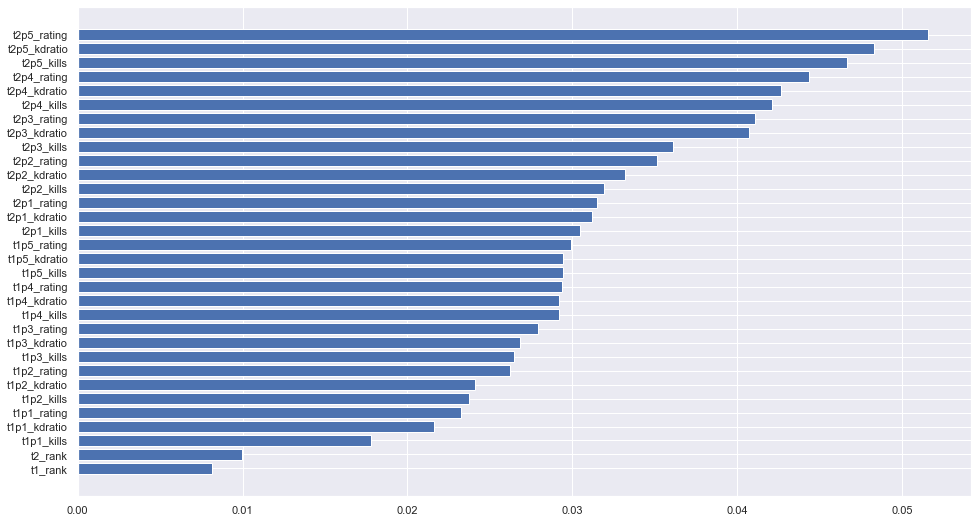

In [36]:
fig = plt.figure(figsize=(16, 9))
sorted_feat = rf.feature_importances_.argsort()
plt.barh(features.columns,rf.feature_importances_[sorted_feat])

plt.show()

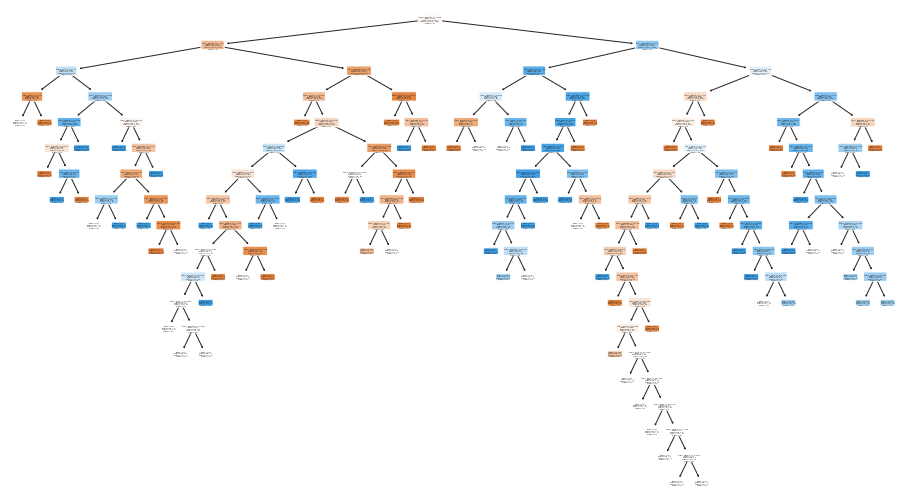

In [ ]:
fig = plt.figure(figsize=(16, 9))

plot_tree(dtc, 
          feature_names=features.columns,
          class_names=["t1", "t2"], 
          filled=True, impurity=True, 
          rounded=True)

plt.show()

In [ ]:
recent_matches_dataset["t1_rank"], 